In [10]:
from typing import Callable, Sequence, Any
from functools import partial

import jax
import jax.numpy as jnp

from torch.utils.data import Dataset
import torch

import numpy as np

import flax
import flax.linen as nn

import optax
import jaxopt

import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import DataLoader

from functions import Fourier, Mixture, Slope, Polynomial, WhiteNoise, Shift
from networks import MixtureNeuralProcess, MLP, MeanAggregator, SequenceAggregator, NonLinearMVN, ResBlock

### Constants

In [11]:
batch_size=128
context_size=64
target_size=32
num_epochs=100
kl_penalty=1e-4
num_posterior_mc=1
rng = jax.random.key(0)
test_resolution=512
dataset_size=128*100

### Dataset

In [12]:
class MixtureDataset(Dataset):
    def __init__(self, dataset_size, key, num_context_samples, num_target_samples, sampler):
        self.key = key
        self.dataset_size = dataset_size
        self.num_context_samples = num_context_samples
        self.num_target_samples = num_target_samples
        self.sampler = sampler
        self.context_xs, self.target_xs, self.context_ys, self.target_ys = self._get_data()

    def __len__(self):
        return self.dataset_size

    def __getitem__(self, idx):
        return self.context_xs[idx], self.context_ys[idx], self.target_xs[idx], self.target_ys[idx]

    def _get_data(self):
        key_data, self.key = jax.random.split(self.key)
        xs, ys = jax.vmap(self.sampler)(jax.random.split(key_data, num=self.dataset_size))
        xs, ys = xs[..., None], ys[..., None]
        # Split into context- and target-points.
        X, x_test = jnp.split(xs, indices_or_sections=(context_size, ), axis=1)
        y, y_test = jnp.split(ys, indices_or_sections=(context_size, ), axis=1)
        return X, x_test, y, y_test

### Data Loader

In [13]:
f1 = Fourier(n=4, amplitude=.5, period=1.0)
f2 = Fourier(n=2, amplitude=.5, period=1.0)
f3 = Fourier(n=6, amplitude=.5, period=2.0)
f4 = Fourier(n=3, amplitude=1.0, period=2.0)

m = Mixture([Shift(f1, y_shift=-2), Shift(f2, y_shift=0.0), Shift(f3, y_shift=2)])
nm = Mixture([WhiteNoise(m.branches[0], 0.05), WhiteNoise(m.branches[1], 0.2), WhiteNoise(m.branches[2], 0.1)])
def joint(
    module: nn.Module,
    data_sampler: Callable[
        [nn.Module, flax.typing.VariableDict, flax.typing.PRNGKey],
        tuple[jax.Array, jax.Array]
    ],
    key: flax.typing.PRNGKey,
    return_params: bool = False
) -> tuple[jax.Array, jax.Array]:
    # Samples from p(Z, X, Y)
    key_param, key_rng, key_data = jax.random.split(key, 3)

    params = module.init({'params': key_param, 'default': key_rng}, jnp.zeros(()))
    xs, ys = data_sampler(module, params, key_data)

    if return_params:
        return xs, ys, params
    return xs, ys


def uniform(
    module: nn.Module,
    params: flax.typing.VariableDict,
    key: flax.typing.PRNGKey,
    n: int,
    bounds: tuple[float, float]
) -> tuple[jax.Array, jax.Array]:

    # Samples from p(X, Y | Z) = p(Y | Z, X)p(X)
    key_xs, key_ys = jax.random.split(key)
    xs = jax.random.uniform(key_xs, (n,)) * (bounds[1] - bounds[0]) + bounds[0]
    ys = jax.vmap(module.apply, in_axes=(None, 0))(params, xs, rngs={'default': jax.random.split(key_ys, n)})
    return xs, ys


data_sampler = partial(
    joint,
    WhiteNoise(f2, 0.1),
    partial(uniform, n=context_size + target_size, bounds=(-1, 1))
)
def numpy_collate(batch):
    transposed_data = list(zip(*batch))
    xs_context = np.array(transposed_data[0])
    ys_context = np.array(transposed_data[1])
    xs_target = np.array(transposed_data[2])
    ys_target = np.array(transposed_data[3])
    return torch.tensor(xs_context), torch.tensor(ys_context), torch.tensor(xs_target), torch.tensor(ys_target)
rng, key = jax.random.split(rng)
dataset = MixtureDataset(dataset_size=dataset_size, key=key, num_context_samples=context_size, num_target_samples=target_size, sampler=data_sampler)

### Model initialization

In [14]:

def f(
        key: flax.typing.PRNGKey,
        x: jax.Array,
        noise_scale: float = 0.2,
        mixture_prob: float = 0.5,
        corrupt: bool = True
):
    key_noise, key_mixture = jax.random.split(key)

    noise = jax.random.normal(key, x.shape) * noise_scale
    choice = jax.random.bernoulli(key_mixture, mixture_prob, x.shape)

    # return choice * (jnp.sin(2 * jnp.pi * x / 2)) + (1 - choice) * (jnp.cos(2 * jnp.pi * 2 * x)) + corrupt * noise
    return choice * (-2 - jnp.cos(2 * jnp.pi * x)) + (1 - choice) * (2 + jnp.cos(2 * jnp.pi * x)) + corrupt * noise


def initialize_np(rng, dataset_size, test_resolution=500):
    rng, key_data, key_test, key_x = jax.random.split(rng, 4)

    keys_data = jax.random.split(key_data, (dataset_size,))
    keys_test = jax.random.split(key_test, (test_resolution,))

    xs = jax.random.uniform(key_x, (dataset_size,)) * 2 - 1
    ys = jax.vmap(f)(keys_data, xs)
    embedding_xs = MLP([64, 64], activation=jax.nn.leaky_relu, activate_final=True, use_layernorm=True)
    embedding_ys = MLP([64, 64], activation=jax.nn.leaky_relu, activate_final=True, use_layernorm=True)
    embedding_both = MLP([64, 64], activation=jax.nn.leaky_relu, activate_final=True, use_layernorm=True)

    projection_posterior = NonLinearMVN(
        MLP([128, 64], activation=jax.nn.leaky_relu, activate_final=False, use_layernorm=True))

    # output_model = nn.Sequential([
    #     ResBlock(
    #         MLP([128, 128], activation=jax.nn.leaky_relu, activate_final=True, use_layernorm=True),
    #     ),
    #     ResBlock(
    #         MLP([128, 128], activation=jax.nn.leaky_relu, activate_final=True, use_layernorm=True),
    #     ),
    #     nn.Dense(2)
    # ])
    output_model = MLP([128, 128, 2], activation=jax.nn.leaky_relu, activate_final=False, use_layernorm=True)
    projection_outputs = NonLinearMVN(output_model)

    posterior_aggregator = MeanAggregator(projection_posterior)

    model = MixtureNeuralProcess(
        embedding_xs, embedding_ys, embedding_both,
        posterior_aggregator,
        projection_outputs
    )

    rng, key1, key2 = jax.random.split(rng, 3)
    params = model.init({'params': key1, 'default': key2}, xs[:, None], ys[:, None], xs[:3, None])
    return model, params


def batch_to_screenernet_input(xs, ys):
    xs = xs[:, :, 0]
    ys = ys[:, :, 0]
    return jnp.concatenate((xs, ys), axis=1)


def initialize_optimizer(params):
    optimizer = optax.chain(
        optax.clip(.1),
        optax.clip_by_global_norm(1.0),
        optax.adamw(learning_rate=1e-3, weight_decay=1e-6),
    )
    opt_state = optimizer.init(params)
    return optimizer, opt_state

@partial(jax.jit, static_argnums=(2))
def screenernet_loss(screenernet, screenernet_input, apply_fn, losses):
    """
    Computes the objective loss of ScreenerNet.
    """
    weights = apply_fn(screenernet, screenernet_input).flatten()
    def body_fun(i, loss_sn):
        loss = losses[i]
        weight = weights[i]
        regularization_term = (1 - weight) * (1 - weight) * loss + weight * weight * jnp.maximum(1 - loss, 0)
        return loss_sn + regularization_term

    loss_screenernet = 0.0
    loss_screenernet = jax.lax.fori_loop(0, len(losses), body_fun, loss_screenernet)
    loss_screenernet = loss_screenernet * (1 / len(losses))
    return loss_screenernet


# @partial(jax.jit, static_argnums=(0, 1, 2, 9, 10))
# def np_losses_batch(apply_fn, elbo_fn, f_size, np_params, xs_context, ys_context, xs_target, ys_target,
#                     key, kl_penalty, num_posterior_mc):
#     """
#     Computes the un-weighted ELBOs for all tasks in a batch.
#     """
#     # Compute ELBO over batch of datasets
#     elbos = jax.vmap(partial(
#         apply_fn,
#         np_params,
#         beta=kl_penalty, k=num_posterior_mc,
#         method=elbo_fn
#     ))(
#         xs_context, ys_context, xs_target, ys_target, rngs={'default': jax.random.split(key, f_size)}
#     )
#     return elbos


@jax.jit
def elementwise_gaussian_ll_loss(y, mean, v):
    eps = 1e-6
    return 0.5 * (jnp.log(jnp.maximum(v, eps)) + (y - mean)**2 / jnp.maximum(v, eps))

@jax.jit
def sample_gaussian_ll_loss(ys, means, vs):
    losses = jax.vmap(elementwise_gaussian_ll_loss, in_axes=(0,0,0))(ys, means, vs)
    return jnp.mean(losses)


@partial(jax.jit, static_argnums=(0, 7))
def np_losses_batch(apply_fn, np_params, xs_context, ys_context, xs_target, ys_target, key, num_posterior_mc):
    """
    Computes the un-weighted log likelihood loss for all tasks in a batch.
    """
    means_batch, stds_batch = jax.vmap(partial(
        apply_fn,
        np_params, 
        k=num_posterior_mc
    ))(
        xs_context, ys_context, xs_target, rngs={'default': jax.random.split(key, batch_size)}
    )
    means_batch = jnp.reshape(means_batch, (means_batch.shape[0], means_batch.shape[1]))
    vs_batch = jnp.square(jnp.reshape(stds_batch, (stds_batch.shape[0], stds_batch.shape[1])))
    ys_target = jnp.reshape(ys_target, (ys_target.shape[0], ys_target.shape[1]))
    losses = jax.vmap(sample_gaussian_ll_loss, in_axes=(0,0,0))(ys_target, means_batch, vs_batch)
    return losses
    

@partial(jax.jit, static_argnums=(0, 8))
def np_weighted_loss(apply_fn, np_params, weights, xs_context, ys_context, xs_target, ys_target, key, num_posterior_mc):
    """
    Computes the weighted loss for a batch of tasks.
    """
    losses = np_losses_batch(apply_fn, np_params, xs_context, ys_context, xs_target, ys_target, key, num_posterior_mc)
    losses = losses - jnp.minimum(0, jnp.min(losses))
    return jnp.multiply(losses, weights).mean()


@partial(jax.jit, static_argnums=(0, 9, 10))
def update_np(
        apply_fn,
        theta: flax.typing.VariableDict,
        opt_state: optax.OptState,
        weights,
        xs_context,
        ys_context,
        xs_target,
        ys_target,
        random_key: flax.typing.PRNGKey,
        optimizer,
        num_posterior_mc
) -> tuple[flax.typing.VariableDict, optax.OptState, jax.Array]:
    # Implements a generic SGD Step
    value, grad = (jax.value_and_grad(np_weighted_loss, argnums=1)
                   (apply_fn, theta, weights, xs_context, ys_context, xs_target, ys_target,
                    random_key, num_posterior_mc))
    updates, opt_state = optimizer.update(grad, opt_state, theta)
    theta = optax.apply_updates(theta, updates)

    return theta, opt_state, value

@partial(jax.jit, static_argnums=(0, 3))
def update_screenernet(tx, screenernet_opt, screenernet_input, apply_fn, screenernet, losses):
    """
    Performs one gradient step on the ScreenerNet.
    """
    loss_grad_fn = jax.value_and_grad(screenernet_loss, argnums=0)
    loss_val, grads = loss_grad_fn(screenernet, screenernet_input, apply_fn, losses)
    updates, opt_state = tx.update(grads, screenernet_opt)
    screenernet = optax.apply_updates(screenernet, updates)
    return loss_val, screenernet


def train(dataset, dataset_size, context_size, num_epochs, rng, kl_penalty, num_posterior_mc):
    """
    Performs training of the NP and ScreenerNet.
    """
    key, rng = jax.random.split(rng)
    np_model, np_params = initialize_np(key, dataset_size)
    key, rng = jax.random.split(rng)
    # sn_model = MLP([2 * context_size, 128], activation=jax.nn.sigmoid, activate_final=False, use_layernorm=True)
    sn_model = nn.Sequential([
        MLP([2 * context_size, 128], activation=jax.nn.leaky_relu, activate_final=False, use_layernorm=True),
        MLP([128, 128, 1], activation=jax.nn.sigmoid, activate_final=True, use_layernorm=False)
    ])
    dummy = jax.random.normal(key, (2 * context_size,))
    screenernet_params = sn_model.init(key, dummy)
    optimizer, opt_state = initialize_optimizer(np_params)
    tx = optax.adam(learning_rate=1e-3)
    sn_opt_state = tx.init(screenernet_params)
    best, best_params = jnp.inf, np_params
    np_losses = list()
    weighted_losses = list()
    screenernet_losses = list()
    for _ in (pbar := tqdm.trange(num_epochs, desc='Optimizing params. ')):
        dl = DataLoader(dataset, shuffle=True, batch_size=batch_size, collate_fn=numpy_collate)
        data_it = iter(dl)
        for _ in range(int(dataset_size / batch_size)):
            batch = next(data_it)
            batch = jax.tree_util.tree_map(lambda tensor: tensor.numpy(), batch)
            xs_context, ys_context, xs_target, ys_target = batch
            screenernet_input = batch_to_screenernet_input(xs_context, ys_context)
            key, rng = jax.random.split(rng)
            losses = np_losses_batch(np_model.apply, np_params,
                                             xs_context, ys_context, xs_target, ys_target,
                                             key, num_posterior_mc=num_posterior_mc)
            loss_np = losses.mean()
            weights = sn_model.apply(screenernet_params, screenernet_input).flatten()
            sum_weights = jnp.sum(weights, axis=None)
            if sum_weights != 0:
              weights = (batch_size / sum_weights) * weights
            rng, key = jax.random.split(rng)
            np_params, opt_state, loss_np_weighted = update_np(np_model.apply, np_params, opt_state,
                                                      weights, xs_context, ys_context, xs_target, ys_target, key, optimizer, num_posterior_mc)
            loss_sn, screenernet_params = update_screenernet(tx, sn_opt_state, screenernet_input,
                                                             sn_model.apply, screenernet_params, losses)
            if loss_np < best:
                best = loss_np
                best_params = np_params
            np_losses.append(loss_np)
            weighted_losses.append(loss_np_weighted)
            screenernet_losses.append(loss_sn)
            pbar.set_description(f'Optimizing params. Losses: {loss_sn:.4f} {loss_np:.4f} {loss_np_weighted: .4f}')
    return np_model, best_params, np_losses, weighted_losses, screenernet_losses


In [15]:
model, params, np_losses, weighted_losses, screenernet_losses=train(dataset, dataset_size, context_size, num_epochs, rng, kl_penalty, num_posterior_mc)

Optimizing params. Losses: 0.1010 0.7225  1.1759: 100%|██████████| 100/100 [47:04<00:00, 28.24s/it]


In [16]:
# Test predictions on functions from the training-distribution
def f(
    key: flax.typing.PRNGKey,
    x: jax.Array,
    noise_scale: float = 0.2,
    mixture_prob: float = 0.5,
    corrupt: bool = True
):
    key_noise, key_mixture = jax.random.split(key)

    noise = jax.random.normal(key, x.shape) * noise_scale

    # return choice * (jnp.sin(2 * jnp.pi * x / 2)) + (1 - choice) * (jnp.cos(2 * jnp.pi * 2 * x)) + corrupt * noise
    return(-2-jnp.cos(2 * jnp.pi * x)) + corrupt * noise
key = jax.random.key(42)
key1, key2, key = jax.random.split(key, 3)
keys_test = jax.random.split(key1, (test_resolution,))
x_test = jnp.linspace(-1, 1, test_resolution)
y_test = jax.vmap(partial(f, corrupt=False))(keys_test, x_test)
x_train, y_train = data_sampler(key2)
x_train, y_train = x_train[..., None], y_train[..., None]

# Split into context- and target-points.
X, x_predict_train = jnp.split(x_train, indices_or_sections=(context_size, ))
y, y_predict_train = jnp.split(y_train, indices_or_sections=(context_size, ))
# Compute ELBO over batch of datasets
# means, stds = model.apply(
#     params, 
#     X, y, x_test[..., None],
#     k=10,
#     rngs={'default': jax.random.key(0)}
# )
means, stds = model.apply(
    params, 
    X, y, x_test[..., None],
    k=1,
    rngs={'default': key}
)
print('prediction-shape', means.shape, stds.shape)  # dim: (len(x_test), k, 1)

prediction-shape (512, 1, 1) (512, 1, 1)


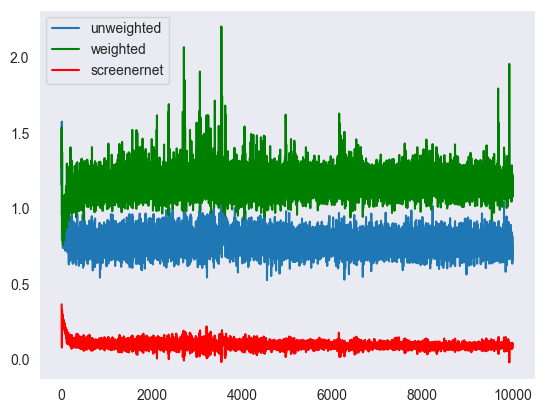

In [17]:
plt.plot(np_losses, label='unweighted')
#plt.plot(jnp.ufunc(jnp.minimum, nin=2, nout=1).accumulate(jnp.asarray(losses)))
plt.plot(weighted_losses, color='green', label='weighted')
plt.plot(screenernet_losses, color='red', label='screenernet')
plt.legend()
plt.grid()

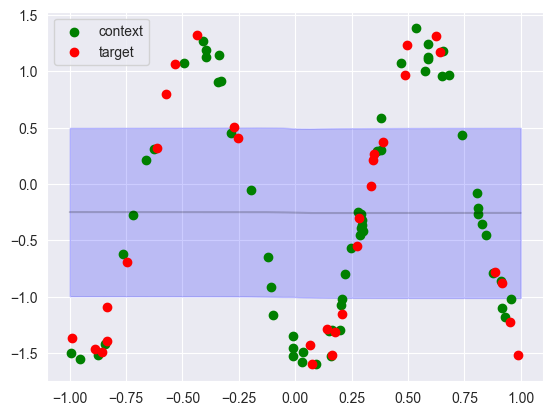

In [18]:
for i in range(means.shape[1]):
    plt.plot(x_test, means[:, i], color='black', alpha=0.2)  # Mixture-components
    plt.fill_between(
        x_test,
        means[:, i, 0] + stds[:, i, 0],
        means[:, i, 0] - stds[:, i, 0],
        color='blue', alpha=0.2
    )

plt.scatter(X, y, color='green', label='context')
plt.scatter(x_predict_train, y_predict_train, color='red', label='target')

plt.legend()